In [18]:
import math
import numpy as np
import math
from datasets import load_dataset
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from SPARQLWrapper import SPARQLWrapper, JSON
import pandas as pd
import re
import json
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd
import os
import time
import random


In [7]:
#Save the two dataset to csv
silverdataset = pd.read_csv('silver.csv')
golddataset = pd.read_csv('gold.csv')

# Load the datasets


In [71]:
training_data = silverdataset
evaluation_data = golddataset

In [ ]:
print(evaluation_data.head())


                                     item            name  \
0   http://www.wikidata.org/entity/Q15786  1. FC Nürnberg   
1  http://www.wikidata.org/entity/Q268530      77 Records   
2  http://www.wikidata.org/entity/Q216153    A Bug's Life   
3     http://www.wikidata.org/entity/Q593    A Gang Story   
4  http://www.wikidata.org/entity/Q192185   Aaron Copland   

                                         description    type  \
0     German sports club based in Nuremberg, Bavaria  entity   
1                                    UK record label  entity   
2  1998 animated film directed by John Lasseter a...  entity   
3                       2011 film by Olivier Marchal  entity   
4  American composer, composition teacher, writer...  entity   

           category    subcategory                    label  
0            sports    sports club  cultural representative  
1             music   record label       cultural exclusive  
2  comics and anime  animated film  cultural representative  


In [ ]:
def heuristic_from_text(column):
    nations = set(pd.read_csv('national_adjectives.csv')["Country"])
    national_adjectives = set(pd.read_csv('national_adjectives.csv')["Adjective"])
    
    column['new_description'] = column.apply(lambda elem: set(elem.iloc[0].split()), axis=1)
    column['length_description_intersection'] = column['new_description'].apply(lambda elem:  len(elem.intersection(national_adjectives)))
    
    column['nations'] = column['new_description'].apply(lambda elem:  len(elem.intersection(nations)))

    return column['length_description_intersection'], column['nations']

column = pd.DataFrame(training_data["description"])
first, second = heuristic_from_text(column)

In [36]:
from pytrends.request import TrendReq

GET_METHOD='get'

requests_args = {
    'headers': {
    'accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.7',
    'accept-language': 'it-IT,it;q=0.9,en-US;q=0.8,en;q=0.7',
    'dnt': '1',
    'priority': 'u=0, i',
    'referer': 'https://trends.google.it/',
    'sec-ch-ua': '"Chromium";v="135", "Not-A.Brand";v="8"',
    'sec-ch-ua-arch': '"arm"',
    'sec-ch-ua-bitness': '"64"',
    'sec-ch-ua-form-factors': '"Desktop"',
    'sec-ch-ua-full-version': '"135.0.7049.85"',
    'sec-ch-ua-full-version-list': '"Chromium";v="135.0.7049.85", "Not-A.Brand";v="8.0.0.0"',
    'sec-ch-ua-mobile': '?0',
    'sec-ch-ua-model': '""',
    'sec-ch-ua-platform': '"macOS"',
    'sec-ch-ua-platform-version': '"15.0.1"',
    'sec-ch-ua-wow64': '?0',
    'sec-fetch-dest': 'document',
    'sec-fetch-mode': 'navigate',
    'sec-fetch-site': 'same-origin',
    'sec-fetch-user': '?1',
    'upgrade-insecure-requests': '1',
    'user-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/135.0.0.0 Safari/537.36',
    'x-client-data': 'COvsygE=',
    'cookie': 'SOCS=CAISNQgEEitib3FfaWRlbnRpdHlmcm9udGVuZHVpc2VydmVyXzIwMjQwOTEwLjA4X3AxGgJpdCACGgYIgI2jtwY; SEARCH_SAMESITE=CgQIv5wB; NID=520=oCAJW4_O8PDH_CsstjICiWM3TKXh0tJdCzNFGXZtFoMMjmugCDsB0sNtfXHUXSIDzOdoB1NVdeWS0IGsSmz-WAGCKjLNxs2MJOetvmhispQTr77BhEtjyaTFbkwQXDvyufeIXRzKhH22KctYgpQv4iwA2R5jtCW6ebQe9MPPKOOQfrYAf971CwKUf2t_-EJ31fj7pIUn27ACSk4gTROzxC6ZOVvmdhJhlqtsIAZBvpC0lcWD1WmpqAryaZ7ejcZOfvIOnjv0_I7S3uivBtTwWpXfsuXU7WroOR7jay1dO2kazhDtWM8oH6HuP7R8CW5lC4b1BaKJbVjZW5GZ51XLhSzS30JmN55ycwndPdb1hXe1Kn_A_m5_LVz760n6rjpbrnOtmYim4d60atQhSqFhrWh4Mzeoax3ediUR4Nq7M8W6ZA4XSkZc7b4JtZJWbBd9MBBm3eVee9Qz5tLBlcx_sufQ0hfx4BwQXumFhsgLj0fb4WHNe7015fbNZ4rGePo0Y5Ec0-i0nXOLIxINiaCT_yRwK09C2zTHBIzgxLSMqS4kV6-fvel52Epo_Ftx74GZbSCe7ey5yKtTovFLc7qLpbQetvOOuiTwHnbp5WvNt_ECNhivejGxJ_1ahKJxiEUJA1B0EmJehEGMgk5R_wd_khH53R0E35UywKBRoWTLE0yPI2Q2dgfqKxbZWHxII0QXA7CrRmvrDkozvyVQ7R6BQUNO5XkV2fwrAOAvnyOL5j_dreLtAyo3Mr7c3UMQewO0IZMCcE_vl-boKxMDA58PwZeg-ujbJH3Zt694rPeZk508eCdYRlHe7vR-C60xQYrErWpHSVEIGr3gDEkPapE3uBZXsEOOJo4MSSNg3sEyJ1OQIX_DHFANwLUdRi6HRsqsOIG7BB_7jRLHBBPKFFzQIR0sw30cunYXIFH8vjw9oyfiAjfqwcpNsXOeOhbT-9JNJImJbX_VcsiU0lWHpIp_8zJ5s6IlgV0IqYLZoypMxAYMRINNqyFhYbXM1L-LMiwItu80ulgpEYqxhpZbyKJ3SZKL9qo24NbEpWuEvYqYWcIr7D8csX-bYWishoGot5fK3efU1H6hN-ugx6wTTRl4EduCFMRCAs6N_G6nEEsvY_Dk3mB2GjD0EJjrJ4lD1mumCpZo7qINaRe9sP6mvsVa-gxJYIdZj6WRVwh_JVA3jyE6lqYQIbMv8bHKYFXQIAMoGtjfTMnpm0etlUb2hSmZS-_bIeb27RdQkBRpj0Rt3BSwAbENtFzxakFYFaWrd8_Wo3PqYM1rHaMtBEiiip73HoRb_QFhXMkoIIRba3DUV7saHBnNBla6O2Zt7MmFcRGwm4oswLsIlpYms49sNoY4t3FtpFswB_ctaxoS0JSk7oXwDuqN6lj7KFb7MkA; OTZ=8027539_48_52_123900_48_436380; GOOGLE_ABUSE_EXEMPTION=ID=36bf4c9ceb0001cc:TM=1744553110:C=r:IP=2.47.87.10-:S=9OpT2XXjua9B4c-DtXoqGTQ; HSID=AJ3iHwBkpzglIz-ne; SSID=A7MCQK7-KEVqgqz5G; APISID=7RidlClsGTRMwE2b/ASRC4MHGwvaFO1Zeu; SAPISID=miXMc_XLiYdcLqXd/AMObk2Zi4f9FSHs4B; __Secure-1PAPISID=miXMc_XLiYdcLqXd/AMObk2Zi4f9FSHs4B; __Secure-3PAPISID=miXMc_XLiYdcLqXd/AMObk2Zi4f9FSHs4B; SID=g.a000vwjD66w7_XG_-O9OIXLgpVrfOyJvphLIWxOdCygl8l12gQ7oRMY3RCEJGdDzykFsEc-lQQACgYKAc8SARISFQHGX2MiRXbt3wzdMytXlLyu4d__zxoVAUF8yKpzZNnChJKcHhKHIZhjvHn40076; __Secure-1PSID=g.a000vwjD66w7_XG_-O9OIXLgpVrfOyJvphLIWxOdCygl8l12gQ7oF6F0X7yvkEzMoC0hCQQlywACgYKAXQSARISFQHGX2MiiAqOnRhADJIN3gF1zFkVXhoVAUF8yKpqLbzuMUFxcBsYyMEXxqBD0076; __Secure-3PSID=g.a000vwjD66w7_XG_-O9OIXLgpVrfOyJvphLIWxOdCygl8l12gQ7ouVL5fyYJHITaG_Tijl9jFgACgYKATgSARISFQHGX2Mil3fmN9f1g2d4_AO7lrKnaBoVAUF8yKrSmQzho_3O9qMDK9RpJyKG0076',
}

}



# class TrendReq(UTrendReq):
#     def _get_data(self, url, method=GET_METHOD, trim_chars=0, **kwargs):
#         return super()._get_data(url, method=GET_METHOD, trim_chars=trim_chars, headers=headers, **kwargs)


# Inizializza pytrends
pytrends = TrendReq(requests_args=requests_args)

# Funzione per ottenere i paesi con il maggior interesse per la keyword
def get_top_countries(keyword, top_n=10):
    try:
        pytrends.build_payload([keyword], timeframe='today 5-y', geo='')  # ultimi 5 anni, globale
        region_df = pytrends.interest_by_region(resolution='COUNTRY')
        
        if not region_df.empty:
            region_df = region_df.sort_values(by=keyword, ascending=False)
            region_df = region_df[[keyword]]
            region_df = region_df.reset_index()
            region_df.columns = ['country', 'interest']
            region_df['keyword'] = keyword
            return region_df[['keyword', 'country', 'interest']].head(top_n)
    except Exception as e:
        print(f"Errore con '{keyword}': {e}")
    return pd.DataFrame(columns=['keyword', 'country', 'interest'])

# Funzione per salvare progressivamente i risultati in un file CSV
def save_trends_distribution(file_name):
    output_file_name = "trends_"+file_name
    # Controlla se il file di output esiste già
    if os.path.exists(output_file_name):
        # Carica il file esistente
        existing_df = pd.read_csv(output_file_name)
        # Raccoglie le keyword già trattate
        processed_keywords = existing_df['keyword'].unique().tolist()
        print(f"🌍 {len(processed_keywords)} keywords già trattate.")
    else:
        existing_df = pd.DataFrame(columns=['keyword', 'country', 'interest'])
        processed_keywords = []
    
    # Carica il dataset di input
    data = pd.read_csv(file_name)
    df = pd.DataFrame(data, columns=["name"])

    # Lista per raccogliere i risultati
    results = []

    # Cicla su ogni entità
    for idx, row in df.iterrows():

        keyword = row["name"]
        
        # Se la keyword è già stata trattata, salta
        if keyword in processed_keywords:
            print(f"🔁 '{keyword}' già trattata, salto.")
            continue
        
        time.sleep(1)
        print(f"Elaboro: {keyword}")
        trend_data = get_top_countries(keyword)
        
        # Aggiungi i nuovi risultati se non sono vuoti
        if not trend_data.empty:
            results.append(trend_data)
        
        # Scrivi progressivamente i risultati
        if results:
            new_results = pd.concat(results, ignore_index=True)
            new_results.to_csv(output_file_name, mode='a', header=not os.path.exists(output_file_name), index=False)
            results = []  # Resetta la lista dei risultati per non aggiungere più volte
        
        # Aggiungi la keyword alla lista delle trattate
        processed_keywords.append(keyword)

    print(f"✅ Processamento completato. Risultati salvati in '{output_file_name}'.")


In [37]:
save_trends_distribution('silver.csv')

Elaboro: 916
Errore con '916': The request failed: Google returned a response with code 429
Elaboro: !!!
Errore con '!!!': The request failed: Google returned a response with code 429


KeyboardInterrupt: 

In [ ]:
# Funzione per ottenere la nazione da Wikidata

def get_country_from_wikidata(wikidata_id):
    sparql = SPARQLWrapper("https://query.wikidata.org/sparql")
    query = f"""
    SELECT ?countryLabel WHERE {{
        wd:{wikidata_id} wdt:P17 ?country .
        SERVICE wikibase:label {{ bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }}
    }}
    """
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    results = sparql.query().convert()
    
    # Estrai il nome della nazione
    try:
        country = results['results']['bindings'][0]['countryLabel']['value']
        return country
    except IndexError:
        return None  # Nessuna nazione trovata
    
def extract_wikidata_id(url):
    match = re.search(r'Q\d+', url)
    return match.group() if match else None

# Dizionario per il caching
cache = {}

# Funzione per ottenere la nazione con caching
def get_country_from_wikidata_with_cache(wikidata_id):
    if wikidata_id in cache:
        return cache[wikidata_id]  # Restituisci il risultato dal cache
    country = get_country_from_wikidata(wikidata_id)  # Fai la richiesta
    cache[wikidata_id] = country  # Salva il risultato nel cache
    return country


In [38]:
dataset = training_data.drop(columns=["item", "name", "description"])

#heuristic on description column
column = pd.DataFrame(training_data["description"])
dataset['h_description'] = heuristic_from_text(column)
# Seleziono le colonne con stringhe da codificare
categorical_columns = ["h_description", "type", "category", "subcategory", "label"]  # Sostituisci con i nomi delle colonne del tuo dataset

# Creo un'istanza di OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)

# Applico l'encoder alle colonne categoriali
encoded_features = encoder.fit_transform(dataset[categorical_columns])
print(encoded_features)

# Converto il risultato in un DataFrame
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_columns))

# Rimuovo le colonne originali e aggiungo quelle codificate
dataset = dataset.drop(columns=categorical_columns)
dataset = pd.concat([dataset, encoded_df], axis=1)

labels = ['label_cultural agnostic', 'label_cultural exclusive', 'label_cultural representative']
X = dataset.drop(columns=labels)  # Sostituisci "label" con il nome della colonna delle etichette
y = dataset[labels]

# Divido il dataset in training e testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Creo e addestro il modello Random Forest
rf_model = RandomForestClassifier(n_estimators=1000, random_state=42)
rf_model.fit(X_train, y_train)

# Faccio predizioni sul dataset di test
y_pred = rf_model.predict(X_test)

# Calcolo l'accuratezza del modello
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuratezza del modello: {accuracy:.2f}")
# Scrivo la matrice di confusione


cm = confusion_matrix(y_test.values.argmax(axis=1), y_pred.argmax(axis=1))
plt.figure(figsize=(10, 7))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.show()





NameError: name 'training_data' is not defined

Accuratezza del modello: 0.68


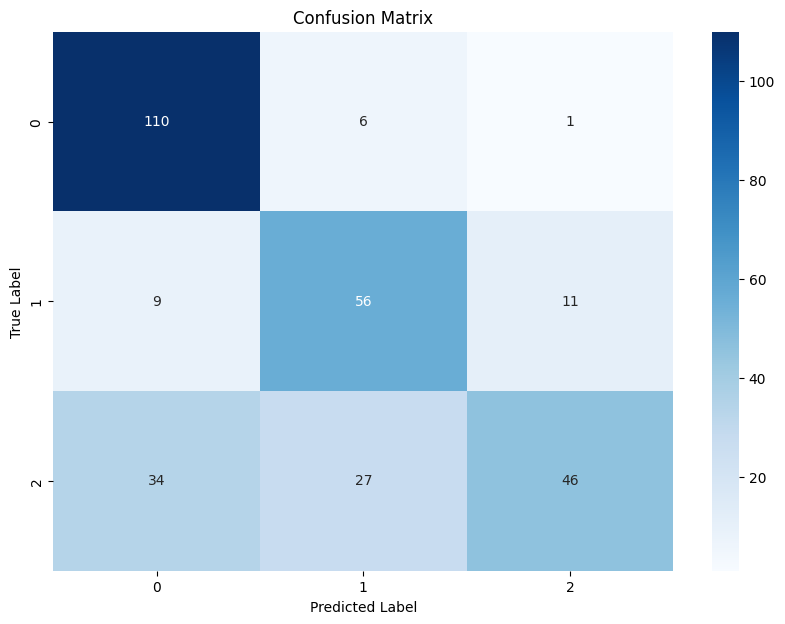

In [79]:
# Rimuovo colonne non utili dal training set
dataset = training_data.drop(columns=["item", "name", "description"])

# Heuristic su 'description'
train_desc = pd.DataFrame(training_data["description"])
dataset['h_description'], dataset['nations'] = heuristic_from_text(train_desc)

# Stesso preprocessing per l'evaluation set
evaluation_dataset = evaluation_data.drop(columns=["item", "name", "description"])
eval_desc = pd.DataFrame(evaluation_data["description"])
evaluation_dataset['h_description'], evaluation_dataset['nations'] = heuristic_from_text(eval_desc)

# Colonne categoriali da codificare
categorical_columns = ["h_description", "nations", "type", "category", "subcategory", "label"]

# One-hot encoding
encoder = OneHotEncoder(sparse_output=False)
encoded_features = encoder.fit_transform(pd.concat([dataset[categorical_columns], evaluation_dataset[categorical_columns]]))
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_columns))

# Pulizia e unione nel dataset di training
dataset = dataset.drop(columns=categorical_columns)
dataset = pd.concat([dataset, encoded_df], axis=1)

# Applico lo stesso encoder all'evaluation set
encoded_eval = encoder.transform(evaluation_dataset[categorical_columns])
encoded_eval_df = pd.DataFrame(encoded_eval, columns=encoder.get_feature_names_out(categorical_columns))
evaluation_dataset = evaluation_dataset.drop(columns=categorical_columns)
evaluation_dataset = pd.concat([evaluation_dataset, encoded_eval_df], axis=1)

# Seleziono feature e target
labels = ['label_cultural agnostic', 'label_cultural exclusive', 'label_cultural representative']
X_train = dataset.drop(columns=labels)
y_train = dataset[labels]
X_test = evaluation_dataset.drop(columns=labels)
y_test = evaluation_dataset[labels]

# Random Forest training
rf_model = RandomForestClassifier(n_estimators=1000, random_state=42)
rf_model.fit(X_train, y_train)

# Predizioni sul test set
y_pred = rf_model.predict(X_test)

# Accuratezza
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuratezza del modello: {accuracy:.2f}")

# Confusion matrix
cm = confusion_matrix(y_test.values.argmax(axis=1), y_pred.argmax(axis=1))
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
